In [1]:
#We get all dependencis we need for a Keras NN
#If you need a module do: "!pip install [module_name]""
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import secrets
import matplotlib.pylab as plt
from keras.utils import plot_model
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense

Using TensorFlow backend.


In [2]:
# Get our `labelled` table as df - This is going to be our training set
# Note that we are removing a URL because we will use that URL for testing
db_conn_str = "mysql+pymysql://{:}:{:}@{:}/{:}".format(secrets.user, secrets.password, secrets.host, secrets.db)
db_conn = create_engine(db_conn_str)

df = pd.read_sql('SELECT * FROM labelled WHERE isHighlight IS NOT NULL AND url<>"https://www.youtube.com/watch?v=0AlFcix7aaY"', con=db_conn)
db_conn.dispose()
df.head()
print('Number of Rows:', len(df.index))

Number of Rows: 17826


In [3]:
#Only take relevant columns for input and classification
X = df[['pitch', 'amplitude', 'subjectivity', 'polarity']]
y = df[['isHighlight']]
X.head()

,pitch,amplitude,subjectivity,polarity
0,49.9597,0.000801,0.000000,0.000000
1,58.7970,0.000655,0.000000,0.000000
2,61.5320,-0.000205,0.000000,0.000000
3,59.4878,0.000786,0.026786,-0.008929
4,59.9587,-0.000265,0.000000,0.000000


In [4]:
# Define the keras model
# Currently - Input Layer = 4 nodes ; Hidden Layer 1 = 10 nodes ; Hidden Layer 2 = 8 ; Output Layer = 1 node
model = Sequential()
model.add(Dense(10, input_dim=4, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [5]:
# Compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
# Fit the keras model on the dataset
model.fit(X, y, epochs=50, batch_size=20)


Epoch 1/50
17826/17826 [==============================] - 1s 74us/step - loss: 0.5407 - accuracy: 0.8258
Epoch 2/50
17826/17826 [==============================] - 1s 59us/step - loss: 0.4265 - accuracy: 0.8601
Epoch 3/50
17826/17826 [==============================] - 1s 58us/step - loss: 0.4207 - accuracy: 0.8601
Epoch 4/50
17826/17826 [==============================] - 1s 57us/step - loss: 0.4144 - accuracy: 0.8601
Epoch 5/50
17826/17826 [==============================] - 1s 54us/step - loss: 0.4105 - accuracy: 0.8601
Epoch 6/50
17826/17826 [==============================] - 1s 67us/step - loss: 0.4047 - accuracy: 0.8601
Epoch 7/50
17826/17826 [==============================] - 1s 74us/step - loss: 0.3991 - accuracy: 0.8601
Epoch 8/50
17826/17826 [==============================] - 1s 72us/step - loss: 0.3936 - accuracy: 0.8601
Epoch 9/50
17826/17826 [==============================] - 1s 74us/step - loss: 0.3884 - accuracy: 0.8601
Epoch 10/50
17826/17826 [=============================

In [7]:
# Evaluate the keras model
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))

17826/17826 [==============================] - 0s 24us/step
Accuracy: 86.14


In [8]:
#Get our test dataframe from `labelled`
db_conn_str = "mysql+pymysql://{:}:{:}@{:}/{:}".format(secrets.user, secrets.password, secrets.host, secrets.db)
db_conn = create_engine(db_conn_str)

df_test = pd.read_sql('SELECT * FROM labelled WHERE isHighlight IS NOT NULL AND url="https://www.youtube.com/watch?v=0AlFcix7aaY" AND url<>"https://www.youtube.com/watch?v=J16IWnr_P8o"', con=db_conn)
db_conn.dispose()
df_test.head()
print('Number of Rows:', len(df_test.index))

Number of Rows: 1980


In [9]:
# Make class predictions for a specific URL
X_test = df_test[['pitch', 'amplitude', 'subjectivity', 'polarity']]
y_test = df_test[['isHighlight']]

predictions_p = model.predict(X_test)

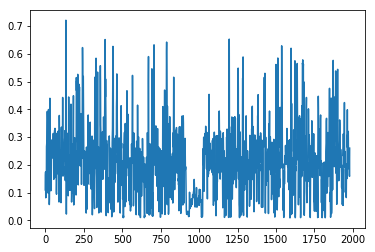

In [10]:
#Print out probabilities of an interval being a highlight
plt.plot(predictions_p)
plt.show()

In [11]:
# So here we have 2 options.
# OPTION 1 
# We could assign a threshold - any point that has a greater probability of being a highlight than the threshold will be classified as a highlight

predictions = []
threshold = 0.33
for i in range(len(predictions_p)):
    if predictions_p[i] >= threshold:
        predictions.append(1)
    else:
        predictions.append(0)



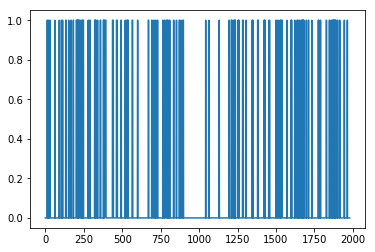

In [12]:
# Print out predictions
plt.plot(predictions)
plt.show()

In [13]:
# OPTION 1 gives us the following results:
correct_prediction, false_positives, false_negatives, true_positives, true_negatives = 0, 0, 0, 0, 0

for i in range(len(y_test.index)):
    if predictions[i] == y.loc[i, 'isHighlight']:
        correct_prediction += 1
    
    if predictions[i] == 1 and y.loc[i, 'isHighlight'] == 1:
        true_positives += 1
    elif predictions[i] == 0 and y.loc[i, 'isHighlight'] == 0:
        true_negatives += 1
    elif predictions[i] == 1 and y.loc[i, 'isHighlight'] == 0:
        false_positives += 1
    elif predictions[i] == 0 and y.loc[i, 'isHighlight'] == 1:
        false_negatives += 1

print()
print('Correct predictions: ', correct_prediction)
print('Total rows:', len(X_test.index))
print('Accuracy:', (correct_prediction/len(X_test.index)))
print()
print('False Positives: ', false_positives)
print('False Negatives: ', false_negatives)
print('True Positives: ', true_positives)
print('True Negatives: ', true_negatives)
print()
print('Total Highlights (Expected): ', y_test['isHighlight'].values.tolist().count(1))
print('Total Highlights (Predicted): ', false_positives + true_positives)


Correct predictions:  1614
Total rows: 1980
Accuracy: 0.8151515151515152

False Positives:  221
False Negatives:  145
True Positives:  24
True Negatives:  1590

Total Highlights (Expected):  433
Total Highlights (Predicted):  245


In [14]:
# OPTION 2
# Just use a function that automatically predicts classes - this is the same as having a threshold of 0.5
predictions = model.predict_classes(X_test)

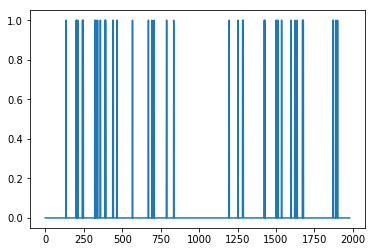

In [15]:
# Print out predictions
plt.plot(predictions)
plt.show()

In [16]:
# OPTION 2 gives us the following results:
correct_prediction, false_positives, false_negatives, true_positives, true_negatives = 0, 0, 0, 0, 0

for i in range(len(y_test.index)):
    if predictions[i] == y.loc[i, 'isHighlight']:
        correct_prediction += 1
    
    if predictions[i] == 1 and y.loc[i, 'isHighlight'] == 1:
        true_positives += 1
    elif predictions[i] == 0 and y.loc[i, 'isHighlight'] == 0:
        true_negatives += 1
    elif predictions[i] == 1 and y.loc[i, 'isHighlight'] == 0:
        false_positives += 1
    elif predictions[i] == 0 and y.loc[i, 'isHighlight'] == 1:
        false_negatives += 1

print()
print('Correct predictions: ', correct_prediction)
print('Total rows:', len(X_test.index))
print('Accuracy:', (correct_prediction/len(X_test.index)))
print()
print('False Positives: ', false_positives)
print('False Negatives: ', false_negatives)
print('True Positives: ', true_positives)
print('True Negatives: ', true_negatives)
print()
print('Total Highlights (Expected): ', y_test['isHighlight'].values.tolist().count(1))
print('Total Highlights (Predicted): ', false_positives + true_positives)


Correct predictions:  1757
Total rows: 1980
Accuracy: 0.8873737373737374

False Positives:  61
False Negatives:  162
True Positives:  7
True Negatives:  1750

Total Highlights (Expected):  433
Total Highlights (Predicted):  68
